In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# SCENARIOS

In [ ]:
'''
First Scenario:
  - L1_loss Lambda = 0.01
  - TVL Lambda = 0.00001

Second Scenario:
  - L1_loss Lambda = 0.1
  - TVL Lambda = 0.00001

Third Scenario:
  - L1_loss Lambda = 1
  - TVL Lambda = 0.00001

Fourth Scenario:
  - L1_loss Lambda = 10
  - TVL Lambda = 0.00001

Fifth Scenario:
  - L1_loss Lambda = 100
  - TVL Lambda = 0

Sixth Scenario:
  - L1_loss Lambda = 100
  - TVL Lambda = 0.00001

Seventh Scenario:
  - L1_loss Lambda = 150
  - TVL Lambda = 0.00001

Eight Scenario:
  - L1_loss Lambda = 150
  - TVL Lambda = 0.0001

Ninth Scenario:
  - L1_loss Lambda = 100
  - TVL Lambda = 0.001

Tenth Scenario:
  - L1_loss Lambda = 100
  - TVL Lambda = 0.0001

Eleventh Scenario:
  - L1_loss Lambda = 100
  - TVL Lambda = 0.00005
'''

# FIRST_SCENARIO_PATH = "drive/MyDrive/SKRIPSI/GANs/0.01_0.00001/generator.h5"
# SECOND_SCENARIO_PATH = "drive/MyDrive/SKRIPSI/GANs/0.1_0.00001/generator.h5"
# THIRD_SCENARIO_PATH = "drive/MyDrive/SKRIPSI/GANs/1_0.00001/generator.h5"
# FOURTH_SCENARIO_PATH = "drive/MyDrive/SKRIPSI/GANs/10_0.00001/generator.h5"
# FIFTH_SCENARIO_PATH = "drive/MyDrive/SKRIPSI/GANs/100_0/generator.h5"
SIXTH_SCENARIO_PATH = "drive/MyDrive/SKRIPSI/GANs/100_0.00001/generator.h5"
# SEVENTH_SCENARIO_PATH = "drive/MyDrive/SKRIPSI/GANs/150_0.00001/generator.h5"
# EIGHT_SCENARIO_PATH = "drive/MyDrive/SKRIPSI/GANs/150_0.0001/generator.h5"
# NINTH_SCENARIO_PATH = "drive/MyDrive/SKRIPSI/GANs/100_0.001/generator.h5"
# TENTH_SCENARIO_PATH = "drive/MyDrive/SKRIPSI/GANs/100_0.0001/generator.h5"
# ELEVENTH_SCENARIO_PATH = "drive/MyDrive/SKRIPSI/GANs/100_0.00005/generator.h5"

V2_PATH = "drive/MyDrive/SKRIPSI/GANs/100_0.00001v2/generator.h5"
V3_PATH = "drive/MyDrive/SKRIPSI/GANs/100_0.00001v3/generator.h5"
VLAST_PATH = "drive/MyDrive/SKRIPSI/GANs/100_0.00001vlast/generator.h5"

AUTOENCODER_PATH = "drive/MyDrive/SKRIPSI/GANs/autoencoderv1/generator.h5"

In [ ]:
# The batch size of 1 produced better results for the U-Net in the original pix2pix experiment
BATCH_SIZE = 1
# Each image is 256x256 in size
IMG_WIDTH = 256
IMG_HEIGHT = 256

TEST_PATH = "drive/MyDrive/SKRIPSI/fixed_dataset/test/"
REAL_TEST_PATH = "drive/MyDrive/SKRIPSI/fixed_dataset/real_testing/"
# PUTIH_TEST_PATH = "drive/MyDrive/SKRIPSI/fixed_dataset/test/putih/"
# KUNING_TEST_PATH = "drive/MyDrive/SKRIPSI/fixed_dataset/test/kuning/"

In [ ]:
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from numpy import ones
from numpy import expand_dims
from numpy import log
from numpy import mean
from numpy import std
from numpy import exp
from math import floor

# Denormalize
def interval_mapping(image, from_min, from_max, to_min, to_max):
    # map values from [from_min, from_max] to [to_min, to_max]
    # image: input array
    from_range = from_max - from_min
    to_range = to_max - to_min
    scaled = np.array((image - from_min) / float(from_range), dtype=float)
    return to_min + (scaled * to_range)

# SSIM

In [ ]:
def eval_gan_ssim(test_dataset, generator_path):
    generator = tf.keras.models.load_model(generator_path)
    ssim_list = []

    for inp, tar in test_dataset.take(10):
        prediction = generator(inp, training=True)
        # plt.figure(figsize=(8, 8))

        image1 = prediction[0] * 0.5 + 0.5
        image2 = tar[0] * 0.5 + 0.5
        
        ssim = tf.image.ssim(image1, image2, max_val=1.0, filter_size=11,
                            filter_sigma=1.5, k1=0.01, k2=0.03)
        ssim_list.append(ssim.numpy())

        # display_list = [prediction[0], tar[0]]
        # title = ['Prediction ' + np.array_str(ssim.numpy()), 'Ground Truth']

        # for i in range(2):
        #     plt.subplot(1, 2, i+1)
        #     plt.title(title[i])
        #     plt.imshow(display_list[i] * 0.5 + 0.5)
        #     plt.axis('off')
        # plt.show()

    ssim_mean = sum(ssim_list) / len(ssim_list)
    return ssim_mean

# FID

In [ ]:
import numpy
from numpy import cov
from numpy import trace
from numpy import iscomplexobj
from numpy import asarray
from numpy.random import shuffle
from scipy.linalg import sqrtm
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.datasets.mnist import load_data
from skimage.transform import resize

def scale_images(images, new_shape):
	images_list = list()
	for image in images:
		# resize with nearest neighbor interpolation
		new_image = resize(image, new_shape, 0)
		# store
		images_list.append(new_image)
	return np.asarray(images_list)

# calculate frechet inception distance
def calculate_fid(model, images1, images2):
	# calculate activations
	act1 = model.predict(images1)
	act2 = model.predict(images2)
	# calculate mean and covariance statistics
	mu1, sigma1 = act1.mean(axis=0), cov(act1, rowvar=False)
	mu2, sigma2 = act2.mean(axis=0), cov(act2, rowvar=False)
	# calculate sum squared difference between means
	ssdiff = numpy.sum((mu1 - mu2)**2.0)
	# calculate sqrt of product between cov
	covmean = sqrtm(sigma1.dot(sigma2))
	# check and correct imaginary numbers from sqrt
	if iscomplexobj(covmean):
		covmean = covmean.real
	# calculate score
	fid = ssdiff + trace(sigma1 + sigma2 - 2.0 * covmean)
	return fid

def eval_gan_fid(test_dataset, generator_path, inception_model):
    generated_images = np.random.randint(100, size=(1, 256, 256, 3))
    real_images = np.random.randint(100, size=(1, 256, 256, 3))
    generator = tf.keras.models.load_model(generator_path)

    for inp, tar in test_dataset.take(-1):
        prediction = generator(inp, training=True)

        image1 = prediction[0] * 0.5 + 0.5
        image2 = tar[0] * 0.5 + 0.5

        image1 = interval_mapping(image1, 0.0, 1.0, 0, 255).astype('uint8')
        image2 = interval_mapping(image2, 0.0, 1.0, 0, 255).astype('uint8')

        image1 = np.expand_dims(image1, axis=0)
        image2 = np.expand_dims(image2, axis=0)

        generated_images = np.vstack((generated_images, image1))
        real_images = np.vstack((real_images, image2))

    generated_images = generated_images[1:]
    real_images = real_images[1:]

    # convert integer to floating point values
    images1 = generated_images.astype('float32')
    images2 = real_images.astype('float32')

    # resize images
    images1 = scale_images(images1, (299,299,3))
    images2 = scale_images(images2, (299,299,3))

    # pre-process images
    images1 = preprocess_input(images1)
    images2 = preprocess_input(images2)

    fid = calculate_fid(inception_model, images1, images2)

    return fid

# IS (not used)

In [ ]:
# from skimage.transform import resize

# def eval_gan_is(test_dataset, generator_path, eps=1E-16):
#     generated_images = np.random.randint(100, size=(1, 256, 256, 3))
#     generator = tf.keras.models.load_model(generator_path)
#     model = InceptionV3()

#     for inp, tar in test_dataset.take(-1):
#         prediction = generator(inp, training=True)
#         image1 = prediction[0] * 0.5 + 0.5
#         image1 = interval_mapping(image1, 0.0, 1.0, 0, 255).astype('uint8')
#         image1 = np.expand_dims(image1, axis=0)
#         generated_images = np.vstack((generated_images, image1))
#     generated_images = generated_images[1:]

#     # x = np.array([np.squeeze(generator(inp, training=True)) for inp, tar in test_dataset.take(10)])
#     subset = generated_images.astype('float32')
#     subset = scale_images(subset, (299,299,3))

#     # is_avg, is_std = calculate_inception_score(subset)
    
# 	# pre-process raw images for inception v3 model
#     processed = preprocess_input(subset)
# 	# predict class probabilities for images
#     yhat = model.predict(processed)
# 	# enumerate splits of images/predictions
#     scores = list()
#     n_part = floor(subset.shape[0] / 10)
#     for i in range(10):
# 		# retrieve p(y|x)
#         ix_start, ix_end = i * n_part, i * n_part + n_part
#         p_yx = yhat[ix_start:ix_end]
# 		# calculate p(y)
#         p_y = expand_dims(p_yx.mean(axis=0), 0)
# 		# calculate KL divergence using log probabilities
#         kl_d = p_yx * (log(p_yx + eps) - log(p_y + eps))
# 		# sum over classes
#         sum_kl_d = kl_d.sum(axis=1)
# 		# average over images
#         avg_kl_d = mean(sum_kl_d)
# 		# undo the log
#         is_score = exp(avg_kl_d)
# 		# store
#         scores.append(is_score)
# 	# average across images
#     is_avg, is_std = mean(scores), std(scores)

#     return is_avg, is_std

# Load Data

In [ ]:
def load(image_file):
  # Read and decode an image file to a uint8 tensor
  image = tf.io.read_file(image_file)
  image = tf.image.decode_jpeg(image)

  # Split each image tensor into two tensors:
  # - one with a real photo
  # - one with a sketch
  w = tf.shape(image)[1]
  w = w // 2
  input_sketch = image[:, w:, :]
  real_photo = image[:, :w, :]

  # Convert both images to float32 tensors
  input_sketch = tf.cast(input_sketch, tf.float32)
  real_photo = tf.cast(real_photo, tf.float32)

  return input_sketch, real_photo

def resize(input_image, real_image, height, width):
  input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  real_image = tf.image.resize(real_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  return input_image, real_image

def normalize(input_image, real_image):
  input_image = (input_image / 127.5) - 1
  real_image = (real_image / 127.5) - 1

  return input_image, real_image

def load_image_test(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = resize(input_image, real_image,
                                   IMG_HEIGHT, IMG_WIDTH)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image


In [ ]:
# TEST_PATH_1 = "drive/MyDrive/SKRIPSI/fixed_dataset/test_1/"

test_dataset = tf.data.Dataset.list_files(TEST_PATH + '*.jpg')
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(BATCH_SIZE)

real_test_dataset = tf.data.Dataset.list_files(REAL_TEST_PATH + '*.jpg')
real_test_dataset = real_test_dataset.map(load_image_test)
real_test_dataset = real_test_dataset.batch(BATCH_SIZE)

# putih_test_dataset = tf.data.Dataset.list_files(PUTIH_TEST_PATH + '*.jpg')
# putih_test_dataset = putih_test_dataset.map(load_image_test)
# putih_test_dataset = putih_test_dataset.batch(BATCH_SIZE)

# kuning_test_dataset = tf.data.Dataset.list_files(KUNING_TEST_PATH + '*.jpg')
# kuning_test_dataset = kuning_test_dataset.map(load_image_test)
# kuning_test_dataset = kuning_test_dataset.batch(BATCH_SIZE)

In [ ]:
print(len(test_dataset))

10


# Evaluation

In [ ]:
# first_ssim = eval_gan_ssim(test_dataset, FIRST_SCENARIO_PATH)
# second_ssim = eval_gan_ssim(test_dataset, SECOND_SCENARIO_PATH)
# third_ssim = eval_gan_ssim(test_dataset, THIRD_SCENARIO_PATH)
# fourth_ssim = eval_gan_ssim(test_dataset, FOURTH_SCENARIO_PATH)
# fifth_ssim = eval_gan_ssim(test_dataset, FIFTH_SCENARIO_PATH)
sixth_ssim = eval_gan_ssim(test_dataset, SIXTH_SCENARIO_PATH)
# seventh_ssim = eval_gan_ssim(test_dataset, SEVENTH_SCENARIO_PATH)
# eight_ssim = eval_gan_ssim(test_dataset, EIGHT_SCENARIO_PATH)
# ninth_ssim = eval_gan_ssim(test_dataset, NINTH_SCENARIO_PATH)
# tenth_ssim = eval_gan_ssim(test_dataset, TENTH_SCENARIO_PATH)
# eleventh_ssim = eval_gan_ssim(test_dataset, ELEVENTH_SCENARIO_PATH)

vlast_ssim = eval_gan_ssim(test_dataset, VLAST_PATH)
autoencoder_ssim = eval_gan_ssim(test_dataset, AUTOENCODER_PATH)

# print("First: %.3f\n" % first_ssim)
# print("Second: %.3f\n" % second_ssim)
# print("Third: %.3f\n" % third_ssim)
# print("Fourth: %.3f\n" % fourth_ssim)
# print("Fifth: %.3f\n" % fifth_ssim)
print("Sixth: %.3f\n" % sixth_ssim)
# print("Seventh: %.3f\n" % seventh_ssim)
# print("Eight: %.3f" % eight_ssim)
# print("Ninth: %.3f" % ninth_ssim)
# print("Tenth: %.3f" % tenth_ssim)
# print("Eleventh: %.3f" % eleventh_ssim)

print("VLAST: %.3f\n" % vlast_ssim)
print("AUTOENCODER: %.3f\n" % autoencoder_ssim)

# real_ssim = eval_gan_ssim(real_test_dataset, V3_PATH)
# print("Best: %.3f\n" % real_ssim)

Sixth: 0.833

VLAST: 0.796

AUTOENCODER: 0.696



In [ ]:
# first_is = eval_gan_is(test_dataset, FIRST_SCENARIO_PATH)
# second_is = eval_gan_is(test_dataset, SECOND_SCENARIO_PATH)

# print("First: {}\nSecond: {}".format(first_is, second_is))

In [ ]:
inception_model = InceptionV3(include_top=False, pooling='avg', input_shape=(299,299,3))

# first_fid = eval_gan_fid(test_dataset, FIRST_SCENARIO_PATH, inception_model)
# second_fid = eval_gan_fid(test_dataset, SECOND_SCENARIO_PATH, inception_model)
# third_fid = eval_gan_fid(test_dataset, THIRD_SCENARIO_PATH, inception_model)
# fourth_fid = eval_gan_fid(test_dataset, FOURTH_SCENARIO_PATH, inception_model)
# fifth_fid = eval_gan_fid(test_dataset, FIFTH_SCENARIO_PATH, inception_model)
sixth_fid = eval_gan_fid(test_dataset, SIXTH_SCENARIO_PATH, inception_model)
# seventh_fid = eval_gan_fid(test_dataset, SEVENTH_SCENARIO_PATH, inception_model)
# eight_fid = eval_gan_fid(test_dataset, EIGHT_SCENARIO_PATH, inception_model)
# ninth_fid = eval_gan_fid(test_dataset, NINTH_SCENARIO_PATH, inception_model)
# tenth_fid = eval_gan_fid(test_dataset, TENTH_SCENARIO_PATH, inception_model)
# eleventh_fid = eval_gan_fid(test_dataset, ELEVENTH_SCENARIO_PATH, inception_model)

# print("First: %.3f\n" % first_fid)
# print("Second: %.3f\n" % second_fid)
# print("Third: %.3f\n" % third_fid)
# print("Fourth: %.3f\n" % fourth_fid)
# print("Fifth: %.3f\n" % fifth_fid)
print("Sixth: %.3f\n" % sixth_fid)
# print("Seventh: %.3f\n" % seventh_fid)
# print("Eight: %.3f" % eight_fid)
# print("Ninth: %.3f\n" % ninth_fid)
# print("Tenth: %.3f\n" % tenth_fid)
# print("Eleventh: %.3f" % eleventh_fid)

real_fid = eval_gan_fid(real_test_dataset, AUTOENCODER_PATH, inception_model)
print("Sixth: %.3f\n" % real_fid)

87924736/87910968 [==============================] - 3s 0us/step


TypeError: ignored

# Save Generated Images

In [ ]:
# from PIL import Image

# gen6 = tf.keras.models.load_model(SIXTH_SCENARIO_PATH)
# counter = 0
# for inp, tar in real_test_dataset.take(10):
#     counter += 1
#     prediction = gen1(inp, training=True)
#     image = prediction[0] * 0.5 + 0.5
#     orig_image = interval_mapping(image, 0.0, 1.0, 0, 255).astype('uint8')
#     test = Image.fromarray(orig_image)
#     test.save("drive/MyDrive/SKRIPSI/GANs/baselineGAN/generated_images/" + str(counter) + ".png")

In [ ]:
# gen2 = tf.keras.models.load_model(SECOND_SCENARIO_PATH)
# counter = 0
# for inp, tar in test_dataset.take(10):
#     counter += 1
#     prediction = gen2(inp, training=True)
#     image = prediction[0] * 0.5 + 0.5
#     orig_image = interval_mapping(image, 0.0, 1.0, 0, 255).astype('uint8')
#     test = Image.fromarray(orig_image)
#     test.save("drive/MyDrive/SKRIPSI/GANs/tvGAN/generated_images/" + str(counter) + ".png")

# Manual Test

In [ ]:
def preprocess_image(image_file):
    # Read and decode an image file to a uint8 tensor
    image = tf.io.read_file(image_file)
    image = tf.image.decode_jpeg(image)

    # Convert both images to float32 tensors
    input_sketch = tf.cast(image, tf.float32)

    # Resize to the coressponding size
    input_sketch = tf.image.resize(input_sketch, [256, 256],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    # Normalize
    input_sketch = (input_sketch / 127.5) - 1
    input_sketch = tf.expand_dims(input_sketch, 0)

    return input_sketch

def generate_and_plot(model, image_file):
    input_sketch = preprocess_image(image_file)
    prediction = model(input_sketch, training=True)
    plt.imshow(prediction[0] * 0.5 + 0.5)
    

In [ ]:
generator = tf.keras.models.load_model(FOURTH_SCENARIO_PATH)

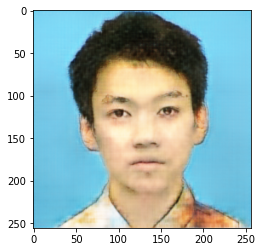

In [ ]:
generate_and_plot(generator, "nathan.jpg")

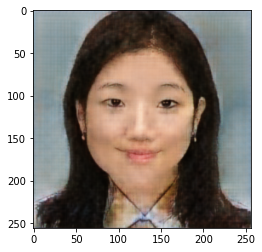

In [ ]:
generate_and_plot(generator, "ester.jpg")

# **SHOW ALL**

In [ ]:
v3_generator = tf.keras.models.load_model(V3_PATH)
vlast_generator = tf.keras.models.load_model(VLAST_PATH)
sixth_generator = tf.keras.models.load_model(SIXTH_SCENARIO_PATH)

In [ ]:
autoencoder_generator = tf.keras.models.load_model(AUTOENCODER_PATH)

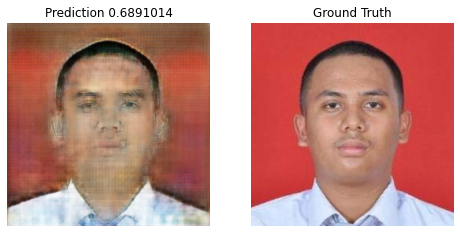

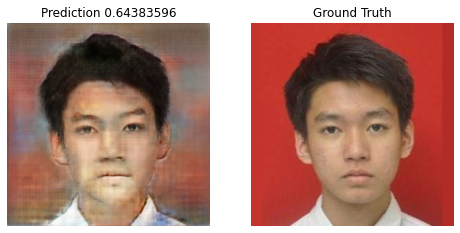

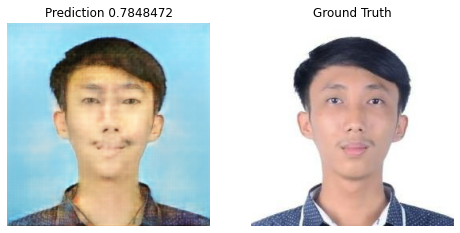

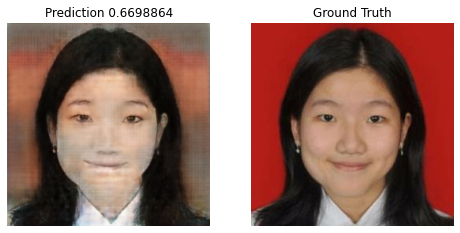

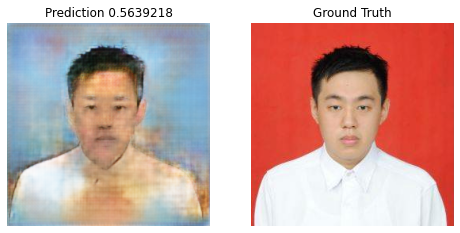

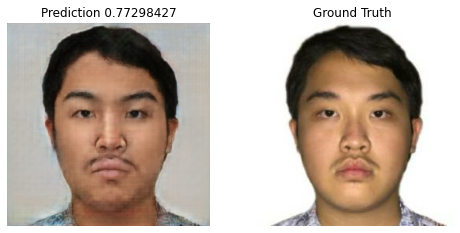

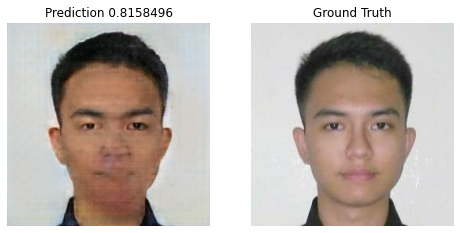

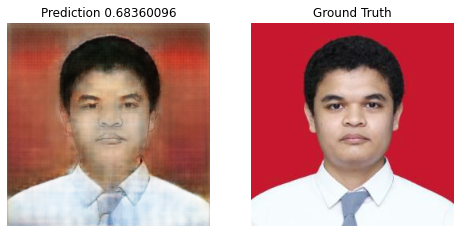

In [ ]:
for inp, tar in real_test_dataset.take(-1):
        prediction = v3_generator(inp, training=True)
        plt.figure(figsize=(8, 8))

        image1 = prediction[0] * 0.5 + 0.5
        image2 = tar[0] * 0.5 + 0.5
        
        ssim = tf.image.ssim(image1, image2, max_val=1.0, filter_size=11,
                            filter_sigma=1.5, k1=0.01, k2=0.03)
        # ssim_list.append(ssim.numpy())

        display_list = [prediction[0], tar[0]]
        title = ['Prediction ' + str(ssim.numpy()), 'Ground Truth']

        for i in range(2):
            plt.subplot(1, 2, i+1)
            plt.title(title[i])
            plt.imshow(display_list[i] * 0.5 + 0.5)
            plt.axis('off')
        plt.show()

In [ ]:
for inp, tar in test_dataset.take(-1):
        prediction = autoencoder_generator(inp, training=True)
        plt.figure(figsize=(8, 8))
        
        display_list = [prediction[0]]

        for i in range(1):
            plt.subplot(1, 1, i+1)
            plt.imshow(display_list[i] * 0.5 + 0.5)
            plt.axis('off')
        plt.show()

In [ ]:
for inp, tar in test_dataset.take(-1):
        # prediction = generator(inp, training=True)
        plt.figure(figsize=(8, 8))

        # image1 = tar[0] * 0.5 + 0.5
        
        display_list = [tar[0]]

        for i in range(1):
            plt.subplot(1, 1, i+1)
            plt.imshow(display_list[i] * 0.5 + 0.5)
            plt.axis('off')
        plt.show()

# **Color transfered**

In [ ]:
PATH = 'drive/MyDrive/SKRIPSI/ct_eval/'
FOLDER_PATH = 'drive/MyDrive/SKRIPSI/color_transfer/'
dark_photo = FOLDER_PATH + '3.jpg'
medium_photo = FOLDER_PATH + '2.jpg'

In [ ]:
for i in range(10):
    image_name = 'before{}.png'.format(i+1)
    before = cv2.imread(PATH + image_name)

    # putih pucat config
    # gamma = 0.8
    # after = gamma_correction(gamma, before)

    # kuning config
    gamma = 0.75
    target = cv2.imread(medium_photo)
    after = color_transfer(target, before)
    after = gamma_correction(gamma, after)

    after  = cv2.cvtColor(after, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(8, 8))
    plt.subplot(1, 1, 1)
    plt.imshow(after)
    plt.axis('off')
    plt.show()

# **EVAL COLOR TRANSFER**

In [ ]:
import cv2
import numpy as np

def gamma_correction(gamma, image):
    lookUpTable = np.empty((1,256), np.uint8)
    for i in range(256):
        lookUpTable[0,i] = np.clip(pow(i / 255.0, gamma) * 255.0, 0, 255)
    res = cv2.LUT(image, lookUpTable)
    return res

def color_transfer(source, target):
	# convert the images from the RGB to L*ab* color space, being
	# sure to utilizing the floating point data type (note: OpenCV
	# expects floats to be 32-bit, so use that instead of 64-bit)
	source = cv2.cvtColor(source, cv2.COLOR_BGR2LAB).astype("float32")
	target = cv2.cvtColor(target, cv2.COLOR_BGR2LAB).astype("float32")
 	# compute color statistics for the source and target images
	(lMeanSrc, lStdSrc, aMeanSrc, aStdSrc, bMeanSrc, bStdSrc) = image_stats(source)
	(lMeanTar, lStdTar, aMeanTar, aStdTar, bMeanTar, bStdTar) = image_stats(target)
	# subtract the means from the target image
	(l, a, b) = cv2.split(target)
	l -= lMeanTar
	a -= aMeanTar
	b -= bMeanTar
	# scale by the standard deviations
	l = (lStdTar / lStdSrc) * l
	a = (aStdTar / aStdSrc) * a
	b = (bStdTar / bStdSrc) * b
	# add in the source mean
	l += lMeanSrc
	a += aMeanSrc
	b += bMeanSrc
	# clip the pixel intensities to [0, 255] if they fall outside
	# this range
	l = np.clip(l, 0, 255)
	a = np.clip(a, 0, 255)
	b = np.clip(b, 0, 255)
	# merge the channels together and convert back to the RGB color
	# space, being sure to utilize the 8-bit unsigned integer data
	# type
	transfer = cv2.merge([l, a, b])
	transfer = cv2.cvtColor(transfer.astype("uint8"), cv2.COLOR_LAB2BGR)
	
	# return the color transferred image
	return transfer

def image_stats(image):
	# compute the mean and standard deviation of each channel
	(l, a, b) = cv2.split(image)
	(lMean, lStd) = (l.mean(), l.std())
	(aMean, aStd) = (a.mean(), a.std())
	(bMean, bStd) = (b.mean(), b.std())
	# return the color statistics
	return (lMean, lStd, aMean, aStd, bMean, bStd)

In [ ]:
# source = cv2.imread('before.png')
# gamma = 0.8
# result = gamma_correction(gamma, source)
# result = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
# plt.figure(figsize=(8, 8))
# plt.subplot(1, 1, 1)
# plt.imshow(result)
# plt.axis('off')
# plt.show()

# import cv2

# gt = cv2.imread('gt.png')

# ssim = tf.image.ssim(gt, source, max_val=255, filter_size=11, filter_sigma=1.5, k1=0.01, k2=0.03)
# print(ssim)
# ssim = tf.image.ssim(gt, result, max_val=255, filter_size=11, filter_sigma=1.5, k1=0.01, k2=0.03)
# print(ssim)

In [ ]:
from statistics import mean

def eval_ct_ssim(path):
    ssim_list_before = []
    ssim_list_after = []

    for i in range(12):
        print(i)
        gt_path = 'gt{}.png'.format(i+1)
        before_path = 'before{}.png'.format(i+1)
        after_path = 'after{}.png'.format(i+1)

        gt = cv2.imread(path + gt_path)
        before = cv2.imread(path + before_path)
        after = cv2.imread(path + after_path)

        ssim = tf.image.ssim(gt, before, max_val=255.0, filter_size=11,
                            filter_sigma=1.5, k1=0.01, k2=0.03)
        ssim_list_before.append(ssim.numpy())

        ssim = tf.image.ssim(gt, after, max_val=255.0, filter_size=11,
                            filter_sigma=1.5, k1=0.01, k2=0.03)
        ssim_list_after.append(ssim.numpy())

    print(ssim_list_before)
    print(mean(ssim_list_before))
    print()
    print(ssim_list_after)
    print(mean(ssim_list_after))

def eval_ct_fid(path, inception):
    before_images = np.random.randint(100, size=(1, 256, 256, 3))
    after_images = np.random.randint(100, size=(1, 256, 256, 3))
    gt_images = np.random.randint(100, size=(1, 256, 256, 3))

    for i in range(12):
        gt_path = 'gt{}.png'.format(i+1)
        before_path = 'before{}.png'.format(i+1)
        after_path = 'after{}.png'.format(i+1)

        gt = cv2.imread(path + gt_path)
        before = cv2.imread(path + before_path)
        after = cv2.imread(path + after_path)

        gt = interval_mapping(gt, 0.0, 1.0, 0, 255).astype('uint8')
        before = interval_mapping(before, 0.0, 1.0, 0, 255).astype('uint8')
        after = interval_mapping(after, 0.0, 1.0, 0, 255).astype('uint8')

        gt = np.expand_dims(gt, axis=0)
        before = np.expand_dims(before, axis=0)
        after = np.expand_dims(after, axis=0)

        before_images = np.vstack((before_images, before))
        after_images = np.vstack((after_images, after))
        gt_images = np.vstack((gt_images, gt))

    before_images = before_images[1:]
    after_images = after_images[1:]
    gt_images = gt_images[1:]

    # convert integer to floating point values
    before_images = before_images.astype('float32')
    after_images = after_images.astype('float32')
    gt_images = gt_images.astype('float32')

    # resize images
    before_images = scale_images(before_images, (299,299,3))
    after_images = scale_images(after_images, (299,299,3))
    gt_images = scale_images(gt_images, (299,299,3))

    # pre-process images
    before_images = preprocess_input(before_images)
    after_images = preprocess_input(after_images)
    gt_images = preprocess_input(gt_images)

    fid_before = calculate_fid(inception_model, before_images, gt_images)
    fid_after = calculate_fid(inception_model, after_images, gt_images)

    print(fid_before)
    print()
    print(fid_after)

In [ ]:
eval_ct_ssim(PATH)

# sixth_ssim = eval_ct_ssim(putih_test_dataset, SIXTH_SCENARIO_PATH, "putih")

# print("Sixth: %.3f\n" % sixth_ssim)

In [ ]:
inception_model = InceptionV3(include_top=False, pooling='avg', input_shape=(299,299,3))

87924736/87910968 [==============================] - 1s 0us/step


In [ ]:
before_images = np.random.randint(100, size=(1, 449, 449, 3))
after_images = np.random.randint(100, size=(1, 449, 449, 3))
gt_images = np.random.randint(100, size=(1, 449, 449, 3))

for i in range(10):
    gt_path = 'gt{}.png'.format(i+1)
    before_path = 'before{}.png'.format(i+1)
    after_path = 'after{}.png'.format(i+1)

    gt = cv2.imread(PATH + gt_path)
    before = cv2.imread(PATH + before_path)
    after = cv2.imread(PATH + after_path)

    # gt = interval_mapping(gt, 0.0, 1.0, 0, 255).astype('uint8')
    # before = interval_mapping(before, 0.0, 1.0, 0, 255).astype('uint8')
    # after = interval_mapping(after, 0.0, 1.0, 0, 255).astype('uint8')

    gt = np.expand_dims(gt, axis=0)
    before = np.expand_dims(before, axis=0)
    after = np.expand_dims(after, axis=0)

    before_images = np.vstack((before_images, before))
    after_images = np.vstack((after_images, after))
    gt_images = np.vstack((gt_images, gt))

before_images = before_images[1:]
after_images = after_images[1:]
gt_images = gt_images[1:]

# convert integer to floating point values
before_images = before_images.astype('float32')
after_images = after_images.astype('float32')
gt_images = gt_images.astype('float32')

# resize images
before_images = scale_images(before_images, (299,299,3))
after_images = scale_images(after_images, (299,299,3))
gt_images = scale_images(gt_images, (299,299,3))

# pre-process images
before_images = preprocess_input(before_images)
after_images = preprocess_input(after_images)
gt_images = preprocess_input(gt_images)

# fid_before = calculate_fid(inception_model, before_images, gt_images)
fid_after = calculate_fid(inception_model, after_images, gt_images)

# print(fid_before)
print()
print(fid_after)


78.9446561000026


In [ ]:
'''
94.705
78.944


'''

# **EVAL AUTOENCODER**

In [ ]:
vlast_generator = tf.keras.models.load_model(VLAST_PATH)
sixth_generator = tf.keras.models.load_model(SIXTH_SCENARIO_PATH)
autoencoder_generator = tf.keras.models.load_model(AUTOENCODER_PATH)

In [ ]:
def eval_ct_ssim(path):
    ssim_list_auto = []
    ssim_list_after = []

    for i in range(12):
        gt_path = 'gt{}.png'.format(i+1)
        autoencoder_path = 'ae{}.png'.format(i+1)
        after_path = 'before{}.png'.format(i+1)

        gt = cv2.imread(path + gt_path)
        autoencoder = cv2.imread(path + autoencoder_path)
        after = cv2.imread(path + after_path)

        ssim = tf.image.ssim(gt, autoencoder, max_val=255.0, filter_size=11,
                            filter_sigma=1.5, k1=0.01, k2=0.03)
        ssim_list_auto.append(ssim.numpy())

        ssim = tf.image.ssim(gt, after, max_val=255.0, filter_size=11,
                            filter_sigma=1.5, k1=0.01, k2=0.03)
        ssim_list_after.append(ssim.numpy())

    print(ssim_list_auto)
    print(mean(ssim_list_auto))
    print()
    print(ssim_list_after)
    print(mean(ssim_list_after))

In [ ]:
eval_ct_ssim(PATH)

[0.7540388, 0.778951, 0.71538836, 0.7256353, 0.69679755, 0.8060806, 0.7215503, 0.73386556, 0.7352014, 0.77026767, 0.7034772, 0.5529616]
0.72451794

[0.8734904, 0.89333487, 0.85693955, 0.883784, 0.86039096, 0.8907216, 0.85073406, 0.87353355, 0.87909484, 0.875568, 0.7867575, 0.8196203]
0.8619975
